In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import data

In [150]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

class Cluster:
    def __init__(self, label, columns, population=0, k=None, scale=True):
        self.label = label
        self.columns = columns
        self.scale = scale
        
        all = data.all.loc[data.all["Population Estimate, 2016"] > population]

        X = all[columns.keys()]
        self.X = X.dropna()
        self.na_count = len(X) - len(self.X)

        if self.scale:
            self.scaler = MinMaxScaler()
            self.X[self.X.columns] = self.scaler.fit_transform(self.X[self.X.columns])

        self.k = self.elbow() if k is None else k

        self.clf = KMeans(n_clusters=self.k)
        self.clf.fit(self.X)

        self.labels = pd.Series(self.clf.labels_, index=self.X.index)
        self.labels.name = "Cluster"

        # Right join drops things not in labels
        self.data = all.join(self.labels, how="right")

    def elbow(self, ks=range(2,10)):
        clfs = [KMeans(n_clusters=k).fit(self.X) for k in ks]
        inertias = [clf.inertia_ for clf in clfs]
        
        slopes = [inertias[k - min(ks)] - inertias[k + 1 - min(ks)] for k in range(min(ks), max(ks) - 1)]

        fractions =  [slopes[i + 1] / slopes[i] for i in range(0, len(slopes) - 1)]

        optimal_k = np.argmin(fractions) + min(ks) + 1

        # Plot it.
        plt.plot(ks, inertias, 'o-')

        # Highlight optimal point.
        radius = 15
        point = (optimal_k, inertias[optimal_k - min(ks)])
        plt.plot(point[0], point[1], 'o', ms=radius * 2, mec='g', mfc='none', mew=2)
        plt.annotate('Optimal K={}'.format(optimal_k), xy=point, xytext=(40, 60),
            textcoords='offset points',
            color='darkgreen',
            size='large',
            arrowprops=dict(
                arrowstyle='simple,tail_width=0.3,head_width=1,head_length=0.8',
                facecolor='g',
                shrinkA=radius ,
                shrinkB=radius * 1.3,
                edgecolor='g',
            ),
        )

        # Title and labels.
        plt.title("Optimal K for {}".format(self.label))
        plt.ylabel("Sum of Squared Error")
        plt.xlabel("Number of Clusters (K)")

        # Show it.
        plt.show()

        return optimal_k

    @property
    def clusters(self):
        cluster_centers = self.scaler.inverse_transform(self.clf.cluster_centers_) if self.scale else self.clf.cluster_centers_

        df = pd.DataFrame(cluster_centers,
            columns=list(self.columns.values())
        ).round(3)
        df.index.name = "Cluster"

        df.insert(0, "Number of Counties", self.labels.value_counts())

        df = df.join(self.data.groupby("Cluster").mean()[[
            "Population Estimate, 2016",
            "Percent of adults with a bachelor's degree or higher, 2014-18",
        ]])

        df = df.rename(columns={
            "Population Estimate, 2016": "Average Population",
            "Percent of adults with a bachelor's degree or higher, 2014-18": "Average Bachelor's Degree %",
        })

        df["Average Population"] = df["Average Population"].round()
        df["Average Bachelor's Degree %"] = df["Average Bachelor's Degree %"].round(1)

        df.index.name = ""

        return df.sort_values(by=["Number of Counties"])

    def counties_in_cluster(self, cluster):
        df = self.data.loc[self.data["Cluster"] == cluster]
        df = df[["State", "County", "Population Estimate, 2016",]]
        return df.rename(columns={ "Population Estimate, 2016": "Population" })

In [176]:
len(data.all.loc[data.all["Population Estimate, 2016"] < 2000])

94

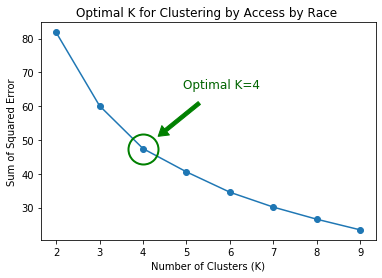

,Number of Counties,"White, low access to stores (%)","Black, low access to stores (%)","Hispanic, low access to stores (%)","Asian, low access to stores (%)","American Indian or Alaska Native, low access to stores (%)","Hawaiian or Pacific Islander, low access to stores (%)",Average Population,Average Bachelor's Degree %
Cluster,,,,,,,,,
2,131,85.448,0.711,10.235,0.300,1.157,0.038,2711.0,20.7
3,183,13.391,15.066,1.215,0.243,0.157,0.014,88424.0,18.4
1,1020,27.620,1.163,3.105,0.378,1.235,0.026,102467.0,23.6
0,1787,9.738,1.027,0.882,0.173,0.524,0.014,112824.0,20.8


In [114]:
Cluster("Clustering by Access by Race ", {
    "PCT_LACCESS_WHITE15": "White, low access to stores (%)",
    "PCT_LACCESS_BLACK15": "Black, low access to stores (%)",
    "PCT_LACCESS_HISP15": "Hispanic, low access to stores (%)",
    "PCT_LACCESS_NHASIAN15": "Asian, low access to stores (%)",
    "PCT_LACCESS_NHNA15": "American Indian or Alaska Native, low access to stores (%)",
    "PCT_LACCESS_NHPI15": "Hawaiian or Pacific Islander, low access to stores (%)",
}).clusters

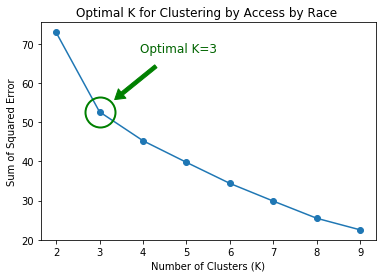

,Number of Counties,"White, low access to stores (%)","Black, low access to stores (%)","Hispanic, low access to stores (%)","Asian, low access to stores (%)","American Indian or Alaska Native, low access to stores (%)","Hawaiian or Pacific Islander, low access to stores (%)",Average Population,Average Bachelor's Degree %
,,,,,,,,,
2,209,14.017,13.560,1.408,0.284,0.174,0.018,97908.0,19.1
0,886,28.007,1.189,3.503,0.426,0.780,0.037,117590.0,24.1
1,1718,9.849,0.983,0.857,0.154,0.469,0.008,114768.0,20.9


In [210]:
Cluster("Clustering by Access by Race ", {
    "PCT_LACCESS_WHITE15": "White, low access to stores (%)",
    "PCT_LACCESS_BLACK15": "Black, low access to stores (%)",
    "PCT_LACCESS_HISP15": "Hispanic, low access to stores (%)",
    "PCT_LACCESS_NHASIAN15": "Asian, low access to stores (%)",
    "PCT_LACCESS_NHNA15": "American Indian or Alaska Native, low access to stores (%)",
    "PCT_LACCESS_NHPI15": "Hawaiian or Pacific Islander, low access to stores (%)",
}, population=5000).clusters

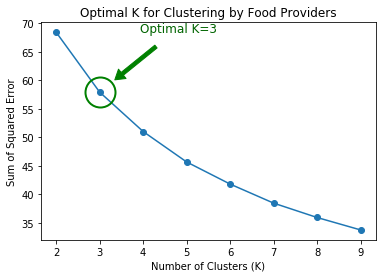

,Number of Counties,"Grocery stores per 1,000 People","Supercenters per 1,000 People","Convenience stores per 1,000 People","Fast-food restaurants per 1,000 People","Full-service restaurants per 1,000 People","Farmers' markets per 1,000 People",Average Population,Average Bachelor's Degree %
,,,,,,,,,
1,392,0.629,0.000,0.859,0.496,1.383,0.179,22507.0,22.0
2,678,0.194,0.052,0.625,0.662,0.768,0.054,38916.0,19.4
0,2070,0.199,0.011,0.536,0.564,0.671,0.037,139081.0,22.2


In [189]:
Cluster("Clustering by Food Providers", {
    "GROCPTH14": "Grocery stores per 1,000 People",
    "SUPERCPTH14": "Supercenters per 1,000 People",
    "CONVSPTH14": "Convenience stores per 1,000 People",
    # "SPECSPTH14": "Specialized food stores per 1,000 People",
    "FFRPTH14": "Fast-food restaurants per 1,000 People",
    "FSRPTH14": "Full-service restaurants per 1,000 People",
    "FMRKTPTH16": "Farmers' markets per 1,000 People",
}).clusters

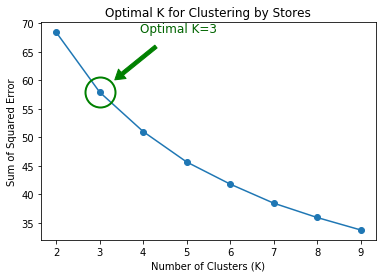

,Number of Counties,"Grocery stores per 1,000 People","Supercenters per 1,000 People","Convenience stores per 1,000 People","Fast-food restaurants per 1,000 People","Full-service restaurants per 1,000 People","Farmers' markets per 1,000 People",Average Population,Average Bachelor's Degree %
,,,,,,,,,
1,393,0.628,0.000,0.859,0.496,1.382,0.179,22526.0,22.0
0,667,0.194,0.052,0.624,0.661,0.768,0.054,38793.0,19.4
2,2080,0.199,0.011,0.537,0.565,0.672,0.037,138643.0,22.2


In [206]:
Cluster("Clustering by Stores", {
    "GROCPTH14": "Grocery stores per 1,000 People",
    "SUPERCPTH14": "Supercenters per 1,000 People",
    "CONVSPTH14": "Convenience stores per 1,000 People",
    # "SPECSPTH14": "Specialized food stores per 1,000 People",
    "FFRPTH14": "Fast-food restaurants per 1,000 People",
    "FSRPTH14": "Full-service restaurants per 1,000 People",
    "FMRKTPTH16": "Farmers' markets per 1,000 People",
}, population=0).clusters

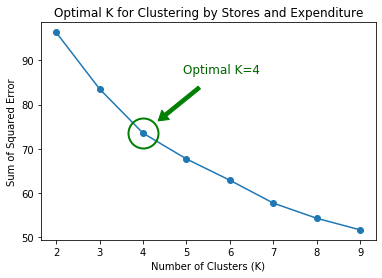

,Number of Counties,"Grocery stores per 1,000 People","Supercenters per 1,000 People","Fast-food restaurants per 1,000 People","Full-service restaurants per 1,000 People","Farmers' markets per 1,000 People","Expenditures per capita, fast food","Expenditures per capita, restaurants",Average Population,Average Bachelor's Degree %
,,,,,,,,,,
1,218,0.802,0.000,0.478,1.436,0.233,569.146,657.852,24532.0,22.6
3,455,0.197,0.059,0.683,0.776,0.058,611.853,613.115,32659.0,19.2
2,877,0.239,0.013,0.537,0.880,0.062,502.556,683.502,133525.0,24.2
0,1590,0.198,0.012,0.581,0.638,0.033,653.949,644.829,116853.0,20.7


In [197]:
Cluster("Clustering by Stores and Expenditure", {
    "GROCPTH14": "Grocery stores per 1,000 People",
    "SUPERCPTH14": "Supercenters per 1,000 People",
    # "CONVSPTH14": "Convenience stores per 1,000 People",
    # "SPECSPTH14": "Specialized food stores per 1,000 People",
    "FFRPTH14": "Fast-food restaurants per 1,000 People",
    "FSRPTH14": "Full-service restaurants per 1,000 People",
    "FMRKTPTH16": "Farmers' markets per 1,000 People",
    # "MILK_PRICE10": "Price of low-fat milk/national average",
    # "SODA_PRICE10": "Price of sodas/national average",
    # "FOODINSEC_13_15": "Statewide Household Food Insecurity",
    "PC_FFRSALES12": "Expenditures per capita, fast food",
    "PC_FSRSALES12": "Expenditures per capita, restaurants",
}, population=0).clusters

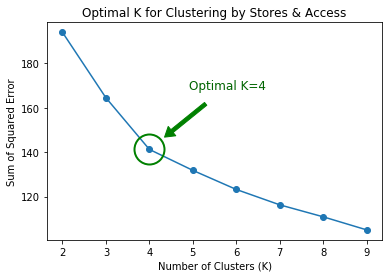

,Number of Counties,"Grocery stores per 1,000 People","Supercenters per 1,000 People","Convenience stores per 1,000 People","Fast-food restaurants per 1,000 People","Full-service restaurants per 1,000 People","Farmers' markets per 1,000 People",Statewide Household Food Insecurity,Average Population,Average Bachelor's Degree %
,,,,,,,,,,
3,271,0.582,0.005,0.743,0.628,1.567,0.186,13.682,44687.0,24.1
2,381,0.207,0.022,0.613,0.535,0.552,0.053,18.763,70882.0,17.4
0,916,0.212,0.017,0.500,0.578,0.743,0.048,11.502,159152.0,24.3
1,1478,0.196,0.022,0.602,0.587,0.671,0.039,14.967,93430.0,20.5


In [181]:
Cluster("Clustering by Stores & Access", {
    "GROCPTH14": "Grocery stores per 1,000 People",
    "SUPERCPTH14": "Supercenters per 1,000 People",
    "CONVSPTH14": "Convenience stores per 1,000 People",
    # "SPECSPTH14": "Specialized food stores per 1,000 People",
    "FFRPTH14": "Fast-food restaurants per 1,000 People",
    "FSRPTH14": "Full-service restaurants per 1,000 People",
    "FMRKTPTH16": "Farmers' markets per 1,000 People",
    # "MILK_PRICE10": "Price of low-fat milk/national average",
    # "SODA_PRICE10": "Price of sodas/national average",
    "FOODINSEC_13_15": "Statewide Household Food Insecurity",
    # "PC_FFRSALES12": "Expenditures per capita, fast food",
    # "PC_FSRSALES12": "Expenditures per capita, restaurants",
    # "PCT_LACCESS_POP15": "Population, low access to store (%)",
    # "PCT_LACCESS_LOWI15": "Low income & low access to store (%), 2015",
}, population=2000).clusters

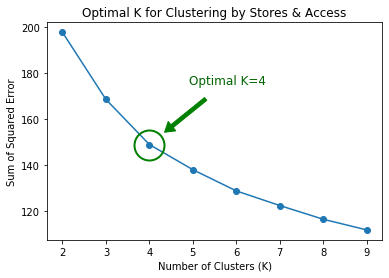

,Number of Counties,"Grocery stores per 1,000 People","Supercenters per 1,000 People","Convenience stores per 1,000 People","Fast-food restaurants per 1,000 People","Full-service restaurants per 1,000 People","Farmers' markets per 1,000 People","Population, low access to store (%)",Low income & low access to store (%),Average Population,Average Bachelor's Degree %
,,,,,,,,,,,
2,123,0.518,0.005,0.787,0.314,0.848,0.104,76.694,32.191,6680.0,18.2
0,276,0.482,0.009,0.758,0.717,1.642,0.173,21.625,7.215,26025.0,25.1
1,1170,0.182,0.024,0.529,0.624,0.686,0.036,29.004,10.820,133829.0,23.3
3,1458,0.210,0.018,0.582,0.544,0.639,0.046,10.585,3.935,108346.0,19.8


In [182]:
Cluster("Clustering by Stores & Access", {
    "GROCPTH14": "Grocery stores per 1,000 People",
    "SUPERCPTH14": "Supercenters per 1,000 People",
    "CONVSPTH14": "Convenience stores per 1,000 People",
    # "SPECSPTH14": "Specialized food stores per 1,000 People",
    "FFRPTH14": "Fast-food restaurants per 1,000 People",
    "FSRPTH14": "Full-service restaurants per 1,000 People",
    "FMRKTPTH16": "Farmers' markets per 1,000 People",
    # "MILK_PRICE10": "Price of low-fat milk/national average",
    # "SODA_PRICE10": "Price of sodas/national average",
    # "FOODINSEC_13_15": "Statewide Household Food Insecurity",
    # "PC_FFRSALES12": "Expenditures per capita, fast food",
    # "PC_FSRSALES12": "Expenditures per capita, restaurants",
    "PCT_LACCESS_POP15": "Population, low access to store (%)",
    "PCT_LACCESS_LOWI15": "Low income & low access to store (%)",
}, population=2000).clusters

In [166]:
Cluster("Low Income, Low Access", {
    "PCT_LACCESS_POP15": "Low access to stores (%)",
    "PCT_LACCESS_LOWI15": "Low income & low access to stores (%)",
}, k=2).clusters

,Number of Counties,Low access to stores (%),Low income & low access to stores (%),Average Population,Average Bachelor's Degree %
,,,,,
1,203,81.458,32.701,6707.0,19.1
0,2918,18.996,6.948,110112.0,21.7


In [177]:
Cluster("Low Access", {
    "PCT_LACCESS_POP15": "Low access to stores (%)",
    "PCT_LACCESS_LOWI15": "Low income & low access to stores (%)",
}, k=2, population=2000).clusters

,Number of Counties,Low access to stores (%),Low income & low access to stores (%),Average Population,Average Bachelor's Degree %
,,,,,
0,419,51.023,21.014,44161.0,19.7
1,2608,16.598,5.942,116584.0,21.9


In [211]:
print(_.to_html(index=False))

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Number of Counties</th>
      <th>White, low access to stores (%)</th>
      <th>Black, low access to stores (%)</th>
      <th>Hispanic, low access to stores (%)</th>
      <th>Asian, low access to stores (%)</th>
      <th>American Indian or Alaska Native, low access to stores (%)</th>
      <th>Hawaiian or Pacific Islander, low access to stores (%)</th>
      <th>Average Population</th>
      <th>Average Bachelor's Degree %</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>209</td>
      <td>14.017</td>
      <td>13.560</td>
      <td>1.408</td>
      <td>0.284</td>
      <td>0.174</td>
      <td>0.018</td>
      <td>97908.0</td>
      <td>19.1</td>
    </tr>
    <tr>
      <td>886</td>
      <td>28.007</td>
      <td>1.189</td>
      <td>3.503</td>
      <td>0.426</td>
      <td>0.780</td>
      <td>0.037</td>
      <td>117590.0</td>
      <td>24.1</td>
    </tr>
    <tr>
      <td>171